## Take home exercise 
### Wenyu Zhao
#### zhwysjtu@gmail.com

### 1. import all necessary packages

In [11]:
import googlemaps
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier as knn

### 2. Augmenting the original dataset
#### The original dataset only provided the addresses of the employes and the intersecting streets as potential bus stops. To improve the dataset and calculate distances, Google Maps Geocoding API is used to retrieve latitude and longitude coordinates for both employee addresses and potential bus stops. Since running the cell below requires using the API repeatedly, the cell is commented out.

In [12]:

# my_gmaps_key = "key_here"
# gClient = googlemaps.Client(key=my_gmaps_key)

# def add2latlng(add):
#     geocode_result = gClient.geocode(add)
#     if len(geocode_result)>0:
#         lat = geocode_result[0]['geometry']['location']['lat']
#         lng = geocode_result[0]['geometry']['location']['lng']
#     else:
#         lat = np.nan
#         lng = np.nan
#     return {'lat':lat, 'lng':lng}
    
# df_bus = pd.read_csv('Potentail_Bust_Stops.csv')
# df_add = pd.read_csv('Employee_Addresses.csv')

# df_bus['address'] = ['@'.join((df_bus.loc[k, 'Street_One'], df_bus.loc[k, 'Street_Two'])) for k in df_bus.index]
# latlng_bus = [add2latlng(k) for k in df_bus['address']]
# latlng_add = [add2latlng(k) for k in df_add['address']]
              
# df_bus = pd.concat([df_bus, pd.DataFrame(latlng_bus)], axis=1)
# df_add = pd.concat([df_add, pd.DataFrame(latlng_add)], axis=1)

# df_bus.to_csv('Potentail_Bust_Stops_new.csv', index=False)
# df_add.to_csv('Employee_Addresses_new.csv', index=False)


### 3. Algorithm 1
#### Two algorithms will be evaluted, and algorithm 1 is used in this section. The algorithm is inspired by KMeans clustering, but without calculating centroids based on the clusters, the potential bus stops are used as "centers" of the clusters to minimize intra-cluster distance.

In [13]:
# Datasets are loaded as data frames
df_bus = pd.read_csv('Potentail_Bust_Stops_new.csv')
df_add = pd.read_csv('Employee_Addresses_new.csv')

#### In the cell below, different functions are defined for the algorithm. Purposes of the functions are described in comments

In [14]:
# calculate the sum of squares as a measure of distance between any two data points (latitude, longitude)
def point_dist(point1, point2):
    sum_of_squares = 0
    for k in range(len(point1)):
        error = point1[k] - point2[k]
        square = error**2
        sum_of_squares += square
    return sum_of_squares

# calculate the sum of distances between all data points in a dataset, employe addresses in this case, and a centroid 
def centroid_dist(data_subset, centroid):
    sum_of_dist = 0
    for k in data_subset:
        dist = point_dist(k, centroid)
        sum_of_dist += dist
    return sum_of_dist

# for a data point, with given potential centroids and the index of the ones selected as cluster centroids, calculate
# which centroid is nearest to the data point
def nearest_centroid_point(point, centroids, selected_index):
    dist = 1e99
    no_centroid = None
    for ind in selected_index:
        dist_new = point_dist(point, centroids[ind])
        if dist_new < dist:
            dist = dist_new
            no_centroid = ind
    return no_centroid
    
# for a set of data, with given potential centroids and the index of the ones selected as cluster centroids, calculate
# which centroid is nearest to the entire dataset
def nearest_centroid_data(data_subset, centroids, selected_index):
    dist = 1e99
    no_centroid = None
    for ind in selected_index:
        dist_new = centroid_dist(data_subset, centroids[ind])
        if dist_new < dist:
            dist = dist_new
            no_centroid = ind
    return no_centroid

# with given dataset, potential centroids and selected cluster centroids, assign each datapoint to its nearest 
# centroid, which is the membership of the data point
def assign_membership(data, centroids, selected_index):
    membership = np.array([nearest_centroid_point(point, centroids, selected_index) for point in data])
    return membership

# with given dataset, potential centroids, selected cluster centroids and the entire membership array, find a new 
# centroid for each data cluster - thus updating the selection of centroids
def update_centroids(data, selected_index, membership, centroids):
    selected_index_new = []
    for k in selected_index:
        membership_index = np.where(membership == k)[0]
        data_cluster = data[membership_index, :]
        new_k = nearest_centroid_data(data_cluster, centroids, range(len(centroids)))
        selected_index_new.append(new_k)
    selected_index_new = np.array(selected_index_new)
    return selected_index_new

# with given dataset, potential centroids, selected cluster centroids and entire membership array, calculate the
# total distance as the sum of distance between each data point and its member cluster
def total_distance(data, membership, centroids, selected_index):
    total_dist = 0
    for ind in selected_index:
        membership_index = np.where(membership == ind)[0]
        data_cluster = data[membership_index, :]
        dist = centroid_dist(data_cluster, centroids[ind])
        total_dist += dist
        
    return total_dist

#### In each loop, 10 centroids are randomly selected as inital centroids. Memberships are then assigned and total distance is calcualted. Then with two stopping criteria designed, the algorithm keeps updating the centroids and recalculating membership & total distance, until the centroids that provide the lowest total distance are found. The loop is repeated a number of times, and the best combination of centroids that give lower total distance than centroids from previous loops are the final centroids. The centroids are the bus stops.

In [15]:
data = df_add[['lat', 'lng']].values
all_centroids = df_bus[['lat', 'lng']].values

final_total_dist = 1e99
final_membership = []
final_index = []

for i in range(100):
    init_index = np.random.randint(len(all_centroids), size=10)
    
    membership = assign_membership(data, all_centroids, init_index)
    total_dist = total_distance(data, membership, all_centroids, init_index)
    
    selected_index = init_index
    step = 0; sigma = 1e99
    
    while (step < 100) & (sigma > 10e-12):
        selected_index = update_centroids(data, selected_index, membership, all_centroids)
        membership = assign_membership(data, all_centroids, selected_index)
        total_dist_new = total_distance(data, membership, all_centroids, selected_index)
        
        sigma = total_dist - total_dist_new
        
        total_dist = total_dist_new
        
        step += 1
    
    if total_dist < final_total_dist:
        final_total_dist = total_dist
        final_membership = membership
        final_index = selected_index
        print "{0}: {1}".format(i, final_total_dist)

0: 0.555787743038
1: 0.497145264397
4: 0.496934483641
8: 0.492944110242
21: 0.490197341876


### 4. Algorithm 2
#### The employee addresses data is clustered first, and the nearest potential bus stop to each cluster is selected.
#### In the cell below, an expriment is run to find the best number of cluster, using KMeans, based on the sum of intra-cluster distances (known as Inertia). 10 is the final answer

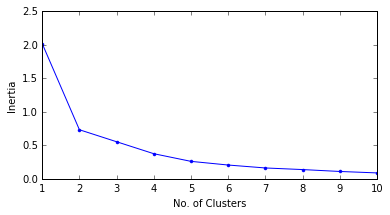

In [16]:
n_clusters = range(1, 11)
inertias = []
for nc in n_clusters:
    cluster = KMeans(n_clusters=nc)
    cluster.fit(data)
    inertias.append(cluster.inertia_)
plt.figure(figsize=(6,3))
plt.plot(range(1,11), inertias, '.-'); plt.xlabel('No. of Clusters'); plt.ylabel('Inertia')
plt.show()

#### In each loop, the addresses coordinates are clusterd into 10 clusters using KMeans, and then for each cluster the best bus stop is selected based on the sum of distances between all addresses in the cluster and a bus stop. The best combination of bus stops are selected from all loops.

In [17]:
final_total_dist_km = 1e99
final_membership_km = []
final_index_km = []

for i in range(100):
    km_cluster = KMeans(n_clusters=10)
    cluster_membership = km_cluster.fit_predict(data)
    
    index_km = []
    for k in range(10):
        membership_index = np.where(cluster_membership == k)[0]
        data_cluster = data[membership_index, :]
        centroid_select = nearest_centroid_data(data_cluster, all_centroids, range(len(all_centroids)))
        index_km.append(centroid_select)
    
    centroid_membership = np.array([index_km[k] for k in cluster_membership])
    total_dist_km = total_distance(data, centroid_membership, all_centroids, index_km)
    
    if total_dist_km < final_total_dist_km:
        final_total_dist_km = total_dist_km
        final_membership_km = cluster_membership
        final_index_km = index_km
        print "{0}: {1}".format(i, final_total_dist_km)

0: 0.538703836922
3: 0.529917715555
65: 0.529917715555


### 5. Final Results
#### Based on the total distance results from both algorithms, results from algorithm 1 are chosen as the final bus stops. To observe the data, employee addresses are shown in the scatter plot below, where each cluster has its own color. The bus stops are shown as red crosses.

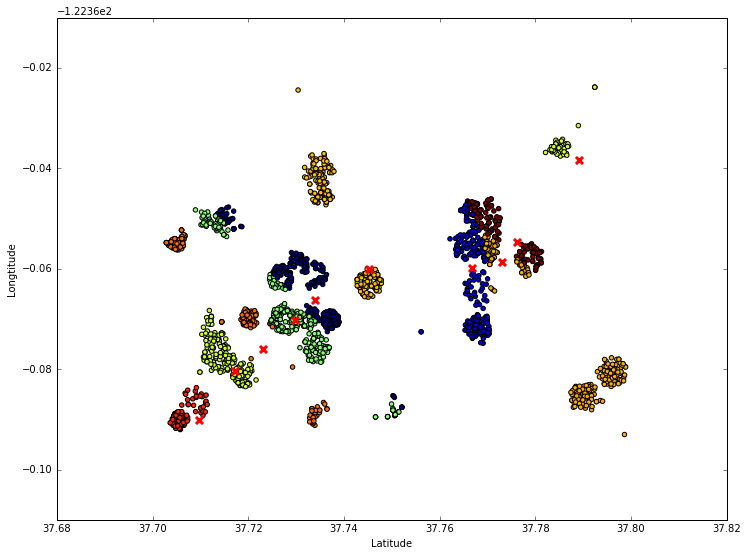

In [18]:
plt.figure(figsize=(12,9))
plt.scatter(data[:,0], data[:,1], c=final_membership)
plt.scatter(all_centroids[final_index,0], all_centroids[final_index,1], color='r', marker = 'x', s=50, linewidths=3)
plt.xlabel('Latitude'); plt.ylabel('Longtitude')
plt.show()

#### The actual street names for the bus stops are printed below

In [19]:
print df_bus.loc[final_index, ['Street_One', 'Street_Two']]

     Street_One       Street_Two
82   MISSION ST      VALENCIA ST
112  MISSION ST          09TH ST
84   MISSION ST          12TH ST
18   MISSION ST          15TH ST
99   MISSION ST         LAURA ST
62   MISSION ST      ADMIRAL AVE
9    MISSION ST  SAINT MARYS AVE
72   MISSION ST         ECKER ST
71   MISSION ST       AMAZON AVE
91   MISSION ST          RUTH ST


#### The locations of the bus stops are shown using a Google Maps plugin

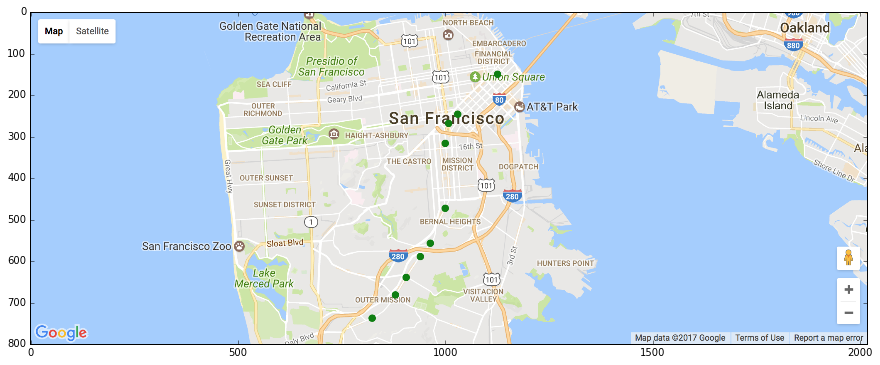

In [26]:
import gmaps

gmaps.configure(api_key = "key_here")
m = gmaps.Map(height="1200px")

final_stop_latlng = df_bus.loc[final_index, ['lat', 'lng']].values
final_stop_latlng = list(map(tuple, final_stop_latlng))
layer = gmaps.symbol_layer(final_stop_latlng, 
                            fill_color="green", stroke_color="green", scale=3)
m.add_layer(layer)
m

# Google Maps plugin won't export properly, therefore an image of the map is shown in place
img = plt.imread('final_bus_stations_GMaps.png')
plt.figure(figsize=(15,9)); plt.imshow(img); plt.show()